# Notebook- Model K15_2 - Custom Loss Function AUC
# Author : V.Albors   Date : 05.04.2020
# Purpose : Create Custom Loss Function 



**Input** :  
  * CSV files that identify the images to use as train and validation. CSV files are in directory csv_dir   
  * Images from train and validation. Images are in directory : imag_dir  
  * Saved model. Model is in directory : model_bin_dir  
  
**Output**:  
  * JMODEL dir - Json network model
  * BMODEL dir - Optimum model with weights
  * RESULTS dir - Print of Network architecture 
                - Train and Validation Accuracy and Loss Curves
                - Metrics of the Model 

 **Process**:  
 * Read Train and Validation images ( identified in the .csv files ) from the imag_dir directory   
 * Create a train and validation input & label tensors (no augmentation)
 * Define the architecture of model  
 * Define a custom loss function                       
 * Train the model with the train dataset with callbacks (  ModuleCheckPoint , Early Stopping)
 * Save the trained model and history of the model in directory model_bin_dir 
 * Paint the Accuracy and Loss curves
 * Create results : Metrics 
 

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.keras.backend.clear_session()  # Reset

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU') 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [3]:
#Tensorflow version 
print(tf.__version__)
from tensorflow.python.platform import build_info as tf_build_info
print(tf_build_info.cuda_version_number)
# Cuda Version 9.0 in v1.10.0
print(tf_build_info.cudnn_version_number)
# CudNN 7 in v1.10.0

2.0.0
10.0
7.6


In [4]:
# Define the name of the model 
Model_directory = "MODELK15"
Model_name = "ModelK15_1"
TRAIN = True

In [5]:
# Import routines
import sys  
subrc_dir = "/home/valborsf/Documents/UOC/PFMProject/"

sys.path.append(subrc_dir)  
from  Models_routines import *
import inspect

# List functions inside the module
import Models_routines as module
functions = inspect.getmembers(module, inspect.isfunction)
lsfunctions = [item[0] for item in functions]
print ( lsfunctions )

['confusion_ROC_AUC', 'create_column_tensor', 'create_label_tensor', 'create_val_test', 'define_dirs', 'extract_images_bm', 'extract_images_train', 'load_hist_model', 'load_images', 'load_images_tf', 'model_load', 'model_load_tf', 'model_load_tf_custom_loss', 'plot_save_acc_loss', 'print_network', 'process_clinical_info', 'read_dataframes', 'read_dataframes_tables', 'reproducible_results', 'save_model', 'save_model_no_opt', 'save_network_json', 'start', 'stop', 'to_one_hot', 'to_one_hot_words', 'xi_squared']


In [6]:
# Reproducible results 
reproducible_results ()

In [7]:
# Define directories
(root_dir,json_dir,imag_dir,csv_dir,model_json_dir,model_bin_dir,results_dir,Tensor_dir) = define_dirs(Model_directory)

In [8]:
# New dataset without SONIC disturbing images
json_dir =  root_dir +"/DataNew/ALL_JSON/"                # .json dir images
imag_dir =  root_dir +"/DataNew/ALL_IMAGES/"              # .png dir - images

# directories for  CSV's
csv_dir =  root_dir +"/DataNew4/CSV/"                      # .csv dir - dftrain, dfval, dftest

In [9]:
# Load train,validation & Test 
(dftrain, dfval, dftest) = read_dataframes(csv_dir)

/home/valborsf/Documents/UOC/PFMProject/DataNew4/CSV/


In [10]:
# Define the label tensor
train_label_tensor = create_label_tensor(dftrain)
val_label_tensor = create_label_tensor(dfval)
#test_label_tensor = create_label_tensor(dftest)

In [11]:
# Create tensors from images
# Load Images 
height_imag = 150 
width_imag = 150
# This step is very time consuming !!!!!!!
train_image_tensor  = load_images_tf(dftrain,height_imag,width_imag)
val_image_tensor  = load_images_tf(dfval,height_imag,width_imag)
#test_image_tensor  = load_images(dftest,height_imag,width_imag)

(2100, 150, 150, 3)
(700, 150, 150, 3)


In [12]:
# This part is to make trials with less samples 
print ( train_image_tensor.shape)
print ( train_image_tensor.ndim)
slice_10_pictures = train_image_tensor[0:10]
slice_10_labels = train_label_tensor [0:10]
val_10_pictures = val_image_tensor[0:10]
val_10_labels = val_label_tensor [0:10]
print ( slice_10_pictures.shape)
print ( slice_10_pictures.ndim)
print ( slice_10_labels)
print ( slice_10_labels.shape)
print ( slice_10_labels.ndim)

(2100, 150, 150, 3)
4
(10, 150, 150, 3)
4
[0. 1. 0. 0. 1. 0. 0. 1. 1. 0.]
(10,)
1


In [13]:
#import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint


# Model 1 : Image to Predict Melanoma

image_inputs = Input(shape=(height_imag,width_imag,3))
m2 = layers.Conv2D(64, (3,3), activation='relu')(image_inputs)
m3 = layers.MaxPooling2D((2,2))(m2)
m4 = layers.Conv2D(32, (3,3),  activation='relu')(m3)
m5 = layers.MaxPooling2D((2,2))(m4)
m6 = layers.Conv2D(128, (3,3), activation='relu')(m5)
m7 = layers.MaxPooling2D((2,2))(m6)
m8 = layers.Flatten()(m7)
m9 = layers.Dense (512, activation='relu')(m8)
m10 = layers.Dropout(0.23)(m9)
benign_malign = layers.Dense (1, activation='sigmoid')(m10)


# Model instantiation
model = Model(image_inputs, benign_malign)


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0     

In [15]:
#Print Network 
print_network (results_dir, model, Model_name)
#Save Network 
save_network_json (model_json_dir, model, Model_name)

In [16]:
import keras.backend as K
#https://github.com/tflearn/tflearn/issues/1028
def roc_auc_score(y_pred, y_true):
    """ ROC AUC Score.
    Approximates the Area Under Curve score, using approximation based on
    the Wilcoxon-Mann-Whitney U statistic.
    Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003).
    Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.
    Measures overall performance for a full range of threshold levels.
    Arguments:
        y_pred: `Tensor`. Predicted values.
        y_true: `Tensor` . Targets (labels), a probability distribution.
    """
    with tf.name_scope("RocAucScore"):
        pos = tf.boolean_mask(y_pred, tf.cast(y_true, tf.bool))
        neg = tf.boolean_mask(y_pred, ~tf.cast(y_true, tf.bool))
        pos = tf.expand_dims(pos, 0)
        neg = tf.expand_dims(neg, 1)
# original paper suggests performance is robust to exact parameter choice
        gamma = 0.2
        p     = 3
        difference = tf.zeros_like(pos * neg) + pos - neg - gamma
        masked = tf.boolean_mask(difference, difference < 0.0)
        return tf.reduce_sum(tf.pow(-masked, p))

def roc_auc_score_loss(y_true, y_pred):
    auc = roc_auc_score(y_pred, y_true)     # Note y_true & y_pred are passed in dif order in keras and tflearn
    tf.print(' AUC Loss: ', auc )
    return auc

Using TensorFlow backend.


In [17]:
# Model Compile
from tensorflow.keras import optimizers
model.compile(loss=roc_auc_score_loss,
               optimizer = optimizers.Adam(lr=1e-4),
#               metrics= [])
               metrics= ['acc', roc_auc_score_loss])
#               metrics= [roc_auc_score])

In [18]:
# Callbacks
callbacks_list = [
# EarlyStopping when the model does not improve in loss

         tf.keras.callbacks.EarlyStopping (
#             monitor = 'roc_auc_score_loss',  # Early stop with roc auc
             monitor = 'val_loss',             # Early stop with val _loss = roc auc 
             verbose=1,                        # log when finishes
             patience = 4,),                   # Interrupt if acc no improve in 4 epochs

#  ModelCheckpoint to store the weights of the best performing epoch. 
    
         tf.keras.callbacks.ModelCheckpoint(filepath=model_bin_dir+"Best_weights"+Model_name+".hdf5", 
             monitor = 'val_loss', # Won't overwritte the model file unless val_loss has
#             monitor = 'roc_auc_score_loss', # Won't overwritte the model file unless val_loss has
             verbose=1,            # improve 
             save_best_only=True),
         
#         keras.callbacks.TensorBoard(
#             log_dir =  Tensor_dir, 
#            histogram_freq = 1,
#            )
#        tf.keras.callbacks.ProgbarLogger(count_mode='samples')             # Display of log show samples seen 
                ]

In [19]:
# Model fit
epochs= 100
batch_size = 128
import time
start_time = time.time()
history = model.fit (
           train_image_tensor, 
           train_label_tensor, 
#           slice_10_pictures, 
#           slice_10_labels, 
           epochs = epochs, 
           batch_size = batch_size, 
           callbacks=callbacks_list,
           validation_data =( val_image_tensor,val_label_tensor))
#           validation_data =( val_10_pictures ,val_10_labels))

elapsed_time = time.time() - start_time

print( time.strftime('Time spent in training :'"%H:%M:%S", time.gmtime(elapsed_time)))

save_model(model, history, model_bin_dir, Model_name)

Train on 2100 samples, validate on 700 samples
Epoch 1/100
 AUC Loss:  31.6257896
 AUC Loss:  31.6257896
 128/2100 [>.............................] - ETA: 51s - loss: 31.6258 - acc: 0.4766 - roc_auc_score_loss: 31.6258 AUC Loss:  29.6489887
 AUC Loss:  29.6489887
 256/2100 [==>...........................] - ETA: 24s - loss: 30.6374 - acc: 0.4609 - roc_auc_score_loss: 30.6374 AUC Loss:  28.9709129
 AUC Loss:  28.9709129
 384/2100 [====>.........................] - ETA: 15s - loss: 30.0819 - acc: 0.4714 - roc_auc_score_loss: 30.0819 AUC Loss:  30.4293137
 AUC Loss:  30.4293137
 512/2100 [======>.......................] - ETA: 11s - loss: 30.1688 - acc: 0.4805 - roc_auc_score_loss: 30.1688 AUC Loss:  28.4334183
 AUC Loss:  28.4334183
 640/2100 [========>.....................] - ETA: 8s - loss: 29.8217 - acc: 0.4938 - roc_auc_score_loss: 29.8217  AUC Loss:  29.128933
 AUC Loss:  29.128933
 768/2100 [=========>....................] - ETA: 6s - loss: 29.7062 - acc: 0.5026 - roc_auc_score_los

 256/2100 [==>...........................] - ETA: 1s - loss: 18.1562 - acc: 0.7148 - roc_auc_score_loss: 18.1562 AUC Loss:  18.8109512
 AUC Loss:  18.8109512
 384/2100 [====>.........................] - ETA: 1s - loss: 18.3745 - acc: 0.7135 - roc_auc_score_loss: 18.3745 AUC Loss:  17.0616302
 AUC Loss:  17.0616302
 512/2100 [======>.......................] - ETA: 1s - loss: 18.0463 - acc: 0.7148 - roc_auc_score_loss: 18.0463 AUC Loss:  14.1892586
 AUC Loss:  14.1892586
 640/2100 [========>.....................] - ETA: 1s - loss: 17.2749 - acc: 0.7141 - roc_auc_score_loss: 17.2749 AUC Loss:  20.3036327
 AUC Loss:  20.3036327
 768/2100 [=========>....................] - ETA: 1s - loss: 17.7797 - acc: 0.7122 - roc_auc_score_loss: 17.7797 AUC Loss:  19.9303226
 AUC Loss:  19.9303226
 896/2100 [===========>..................] - ETA: 1s - loss: 18.0869 - acc: 0.6987 - roc_auc_score_loss: 18.0869 AUC Loss:  19.9460068
 AUC Loss:  19.9460068
1024/2100 [=============>................] - ETA: 1s

 768/2100 [=========>....................] - ETA: 1s - loss: 11.3526 - acc: 0.7734 - roc_auc_score_loss: 11.3526 AUC Loss:  13.4755526
 AUC Loss:  13.4755526
 896/2100 [===========>..................] - ETA: 1s - loss: 11.6559 - acc: 0.7690 - roc_auc_score_loss: 11.6559 AUC Loss:  15.4538612
 AUC Loss:  15.4538612
1024/2100 [=============>................] - ETA: 1s - loss: 12.1306 - acc: 0.7617 - roc_auc_score_loss: 12.1306 AUC Loss:  16.5710907
 AUC Loss:  16.5710907
1152/2100 [===============>..............] - ETA: 0s - loss: 12.6240 - acc: 0.7543 - roc_auc_score_loss: 12.6240 AUC Loss:  14.4747095
 AUC Loss:  14.4747095
1280/2100 [=================>............] - ETA: 0s - loss: 12.8091 - acc: 0.7523 - roc_auc_score_loss: 12.8091 AUC Loss:  13.9091396
 AUC Loss:  13.9091396
1408/2100 [===================>..........] - ETA: 0s - loss: 12.9091 - acc: 0.7507 - roc_auc_score_loss: 12.9091 AUC Loss:  9.89015198
 AUC Loss:  9.89015198
1536/2100 [====================>.........] - ETA: 0s

In [20]:
# Import Model Test if not need to Train 
if not TRAIN :
    model = model_load ( model_bin_dir, Model_name)

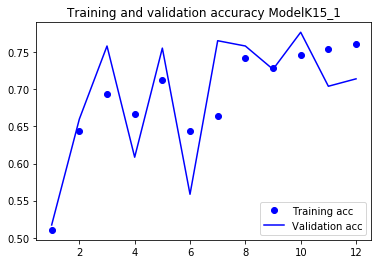

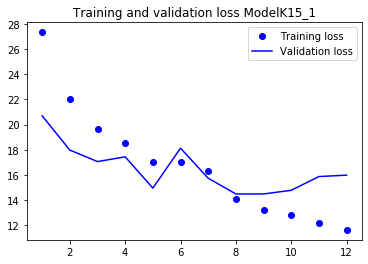

In [21]:
# Display curves of loss and accuracy during training and save results 
plot_save_acc_loss(results_dir, history.history, Model_name)

In [52]:
# Load Model 
# Load weights 
# Import with this compatibility to solve the problem 
# module 'tensorflow' has no attribute 'placeholder'`.

 
#model = build_model()
#model.load_weights('my_weights.model')
from tensorflow.keras.models import load_model
TRAIN = False
if not TRAIN :
    Model_name = "ModelK15_1"
# Special form of loading models that contain custom components 
    model = load_model(model_bin_dir+Model_name+'.h5', custom_objects = {"roc_auc_score_loss": roc_auc_score_loss})
    model.load_weights(model_bin_dir+"Best_weights"+Model_name+".hdf5")

In [53]:
# Create tensors from images
# Load Images 

# This step is very time consuming !!!!!!!

test_image_tensor  = load_images_tf(dftest,height_imag,width_imag)

(700, 150, 150, 3)


In [54]:
# Define the label tensor
test_label_tensor = create_label_tensor(dftest)

In [55]:
#  ROC /AUC
# Model evaluate 
# Returns the loss value & metrics values for the model in test mode.
scores = model.evaluate(test_image_tensor, test_label_tensor, batch_size = 128, verbose=2)

 AUC Loss:  14.4593449
 AUC Loss:  14.4593449
 AUC Loss:  16.6315517
 AUC Loss:  16.6315517
 AUC Loss:  17.9427452
 AUC Loss:  17.9427452
 AUC Loss:  16.7114143
 AUC Loss:  16.7114143
 AUC Loss:  13.6515903
 AUC Loss:  13.6515903
 AUC Loss:  3.36554265
 AUC Loss:  3.36554265
700/1 - 1s - loss: 9.0861 - acc: 0.7400 - roc_auc_score_loss: 13.7937


In [56]:
model.metrics_names
# Loss + Accuracy + roc auc score 
scores

[14.806719015666417, 0.74, 13.793697]

In [57]:
y_pred_keras = model.predict(test_image_tensor).ravel()   # y_pred_probabilities
y_test = dftest.bm.astype('category').cat.codes           # Ground truth 

In [58]:
print ( y_pred_keras[0:5])
print ( y_test[0:5])

[0.60341644 0.49422768 0.50234085 0.40771875 0.3763198 ]
0    1
1    1
2    0
3    0
4    0
dtype: int8


In [59]:
# Compute AUC score from sklearn 
import sklearn 
from sklearn.metrics import roc_curve, auc
# y_test true labels 
# y_pred_keras predictions 
print ( sklearn.metrics.roc_auc_score(y_test, y_pred_keras)) 

0.8406535947712419


In [67]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test,y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.8406535947712419


In [79]:
print (auc_keras.dtype)

float64


In [64]:
gamma = 0.2
p     = 3

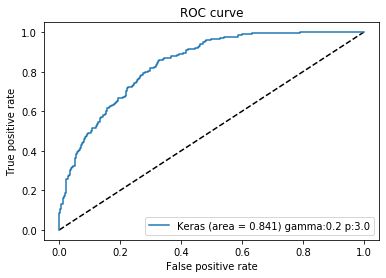

In [81]:
# Print the ROC curves
import matplotlib.pyplot as plt

fig1 = plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras), figure = fig1)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras)+
          ' gamma:{:.1f}'.format(gamma)+ 
          ' p:{:.1f}'.format(p), figure = fig1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
# plt.show()
# fig1.savefig(dir + name+'_Test_ROC.png')

In [60]:
tf.keras.backend.clear_session()  # Reset